##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Core API 빠르게 시작하기

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/core/quickstart_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 빠른 시작 튜토리얼은 [TensorFlow Core 하위 수준 API](https://www.tensorflow.org/guide/core)를 사용하여 연료 효율성을 예측하는 다중 선형 회귀 모델을 빌드하고 훈련하는 방법을 보여줍니다. 1970년대 후반과 1980년대 초반 자동차의 연비 데이터가 포함된 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} 데이터세트를 사용합니다.

다음과 같은 일반적인 머신러닝 프로세스를 진행하게 됩니다.

1. 데이터세트를 로드합니다.
2. [입력 파이프라인](../data.ipynb)을 빌드합니다.
3. 다중 [선형 회귀](https://developers.google.com/machine-learning/glossary#linear-regression){:.external} 모델을 빌드합니다.
4. 모델의 성능을 평가합니다.

## 설치하기

TensorFlow 및 기타 필요한 라이브러리를 가져와서 시작합니다.

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 21:39:36.523921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:39:36.524024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:39:36.524034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TensorFlow version: 2.11.0


## 데이터세트 로드 및 전처리하기

다음으로 [UCI 머신러닝 리포지토리](https://archive.ics.uci.edu/ml/){:.external}로부터 [Auto MPG 데이터세트](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external}를 로드하고 전처리해야 합니다. 이 데이터세트는 실린더, 배기량, 마력 및 중량과 같은 다양한 양적 및 범주적 특성을 사용하여 1970년대 후반과 1980년대 초반 자동차의 연비를 예측합니다.

이 데이터세트에 몇 가지 알 수 없는 값이 있습니다. `pandas.DataFrame.dropna`를 사용하여 누락된 값을 삭제하고 `tf.convert_to_tensor`와 `tf.cast` 함수를 사용하여 데이터세트를 `tf.float32` 텐서 유형으로 변환해야 합니다.

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

다음으로 데이터세트를 훈련 세트와 테스트 세트로 분할합니다. 바이어스된 분할을 방지하려면 `tf.random.shuffle`을 사용하여 데이터세트를 셔플해야 합니다.

In [4]:
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

`"Origin"` 특성을 원-핫 인코딩하여 기본 특성 엔지니어링을 수행합니다. `tf.one_hot` 함수는 이 범주형 열을 3개의 개별 바이너리 열로 변환하는 경우 유용합니다.

In [5]:
def onehot_origin(x):
  origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
  origin_oh = tf.one_hot(origin - 1, 3)
  x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
  return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

이 예제는 예측 변수 또는 특성이 매우 다른 척도로 사용되는 다중 회귀 문제를 보여줍니다. 따라서 각 특성의 평균과 단위 분산이 0(제로)이 되도록 데이터를 표준화하는 것이 좋습니다. 표준화를 위해 `tf.reduce_mean` 및 `tf.math.reduce_std` 함수를 사용합니다. 그런 다음 회귀 모델의 예측을 비표준화하여 원래 단위의 값을 얻을 수 있습니다.

In [6]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [7]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

## 머신 러닝 모델 빌드하기

TensorFlow Core API를 사용하여 선형 회귀 모델을 빌드합니다. 다중 선형 회귀 수식은 다음과 같습니다.

$${\mathrm{Y}} = {\mathrm{X}}w + b$$

여기서,

- $\underset{m\times 1}{\mathrm{Y}}$: 대상 벡터
- $\underset{m\times n}{\mathrm{X}}$: 특성 행렬
- $\underset{n\times 1}w$: 가중치 벡터
- $b$: 바이어스

`@tf.function` 데코레이터를 사용하여 해당 Python 코드를 추적하고 호출 가능한 TensorFlow 그래프를 생성합니다. 이 접근 방식은 훈련 후 모델을 저장하고 로드하는 경우에 유용합니다. 또한 레이어가 많고 복잡한 작업이 있는 모델에 성능 향상을 제공할 수 있습니다. 

In [8]:
class LinearRegression(tf.Module):

  def __init__(self):
    self.built = False

  @tf.function
  def __call__(self, x):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_b = tf.random.uniform(shape=[])
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    y = tf.add(tf.matmul(x, self.w), self.b)
    return tf.squeeze(y, axis=1)

각 예제에서 모델은 특성과 바이어스 항의 가중치 합계를 계산하여 입력한 자동차의 MPG 예측값을 반환합니다. 그런 다음 이 예측값을 비표준화하면 원래 단위의 값을 얻을 수 있습니다.

In [9]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

array([6.8007374], dtype=float32)

## 손실 함수 정의하기

이제 훈련 프로세스를 진행하는 동한 모델의 성능을 평가하는 손실 함수를 정의합니다.

회귀 문제는 연속 출력을 다루기 때문에 MSE(평균 제곱 오차)는 손실 함수에 대한 이상적인 선택이 됩니다. MSE는 다음 수식으로 정의합니다.

$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$$

여기서,

- $\hat{y}$: 예측의 벡터
- $y$: 실제 대상의 벡터

이 회귀 문제의 목표는 MSE 손실 함수를 최소화하는 최적의 가중치 벡터 $w$와 바이어스 $b$를 찾는 것입니다. 

In [10]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

## 모델 훈련 및 평가하기

훈련에 미니 배치를 사용하면 메모리 효율성이 높아지고 더 빠른 수렴이 가능해집니다. `tf.data.Dataset` API에는 배치와 셔플링에 유용한 함수가 있습니다. API를 사용하면 간단하고 재사용 가능한 부분으로부터 복잡한 입력 파이프라인까지 빌드할 수 있습니다. TensorFlow 입력 파이프라인 빌드에 대한 자세한 내용은 [이 가이드](https://www.tensorflow.org/guide/data)에서 확인하세요.

In [11]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

다음으로는 MSE 손실 함수와 입력 매개변수에 대한 그래디언트를 사용하여 모델의 매개변수를 반복적으로 업데이트하는 훈련 루프를 작성합니다.

이 반복 접근 방식을 [경사 하강](https://developers.google.com/machine-learning/glossary#gradient-descent){:.external}이라고 합니다. 각 반복마다 계산된 그래디언트의 반대 방향으로 단계를 수행하여 모델의 매개변수를 업데이트합니다. 이 단계의 크기는 구성 가능한 하이퍼 매개변수인 학습률에 의해 결정됩니다. 함수의 그래디언트는 가장 가파른 상승 방향을 나타냅니다. 따라서 반대 방향으로 단계를 수행하는 것은 가장 가파른 하강 방향을 나타내며 궁극적으로 MSE 손실 함수를 최소화하는 데 도움이 됩니다.

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = lin_reg(x_batch)
      batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, lin_reg.variables)
    for g,v in zip(grads, lin_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance 
    batch_losses_train.append(batch_loss)
  
  # Iterate through the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = lin_reg(x_batch)
    batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance 
    batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
  train_loss = tf.reduce_mean(batch_losses_train)
  test_loss = tf.reduce_mean(batch_losses_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")

Mean squared error for step 0: 2.866


Mean squared error for step 10: 0.453


Mean squared error for step 20: 0.285


Mean squared error for step 30: 0.231


Mean squared error for step 40: 0.209


Mean squared error for step 50: 0.203


Mean squared error for step 60: 0.194


Mean squared error for step 70: 0.184


Mean squared error for step 80: 0.186


Mean squared error for step 90: 0.176



Final train loss: 0.177
Final test loss: 0.157


시간 경과에 따른 MSE 손실의 변화를 플로팅합니다. 지정된 [검증 세트](https://developers.google.com/machine-learning/glossary#validation-set){:.external} 또는 [테스트 세트](https://developers.google.com/machine-learning/glossary#test-set){:.external}에서 성능 메트릭을 계산하면 모델이 훈련 데이터세트에 과대적합되지 않고 보이지 않는 데이터로 잘 일반화될 수 있습니다.

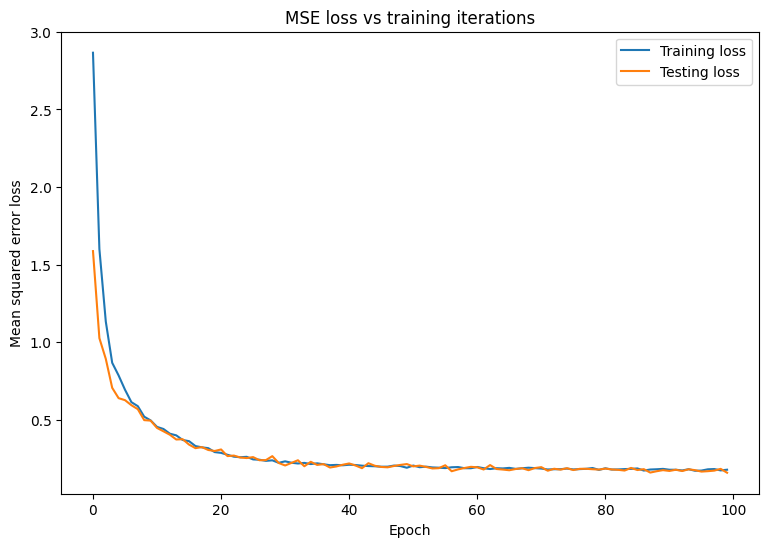

In [13]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

모델이 훈련 데이터와 잘 맞는 동시에 보이지 않는 테스트 데이터에도 잘 일반화하는 것처럼 보입니다.

## 모델 저장하기 및 로드하기

먼저 원시 데이터를 선택하고 다음 연산을 수행하는 내보내기 모듈을 만들어 봅니다.

- 특성 추출
- 정규화
- 예측
- 비정규화

In [14]:
class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y 

In [15]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

현재 상태로 모델을 저장하기 위해 `tf.saved_model.save` 함수를 사용할 수 있습니다. 예측을 위해 저장된 모델을 로드하려면 `tf.saved_model.load` 함수를 사용합니다.

In [16]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpecba8ozw/lin_reg_export/assets


In [17]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([28.097498, 26.193336, 33.564373, 27.719315, 31.787924, 24.014559,
       24.421043, 13.45958 , 28.562454, 27.368694], dtype=float32)

## 결론

축하드립니다! TensorFlow Core 하위 수준 API를 사용하여 회귀 모델을 훈련했습니다.

TensorFlow Core API 사용에 대한 더 많은 예제는 다음 가이드를 확인하세요.

- 이진 분류를 위한 [로지스틱 회귀](./logistic_regression_core.ipynb)
- 손으로 작성한 숫자 인식을 위한 [멀티 레이어 퍼셉트론](./mlp_core.ipynb)
